In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2024-08-08 14:14:57.855019: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/catarinavuzi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### **DenseNet169 model and a different base model**

- Trying differ transfer model and  increasing the epoch size helped in getting better results.

- There is not a big difference  between the base models. They almost have the same accuracy scores.

- There was a difference  in the scores of the validation accuracy in the first base model de scores pretty much remained the same. On the other hand, on this base model  the val accuracy  changed. 

In [2]:
##The size of the image
image_size = (224, 224)

batch_size = 10

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "/Users/catarinavuzi/Downloads/cracked_uncracked_images",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 200 files belonging to 2 classes.
Using 160 files for training.
Using 40 files for validation.


2024-08-08 14:15:15.007222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


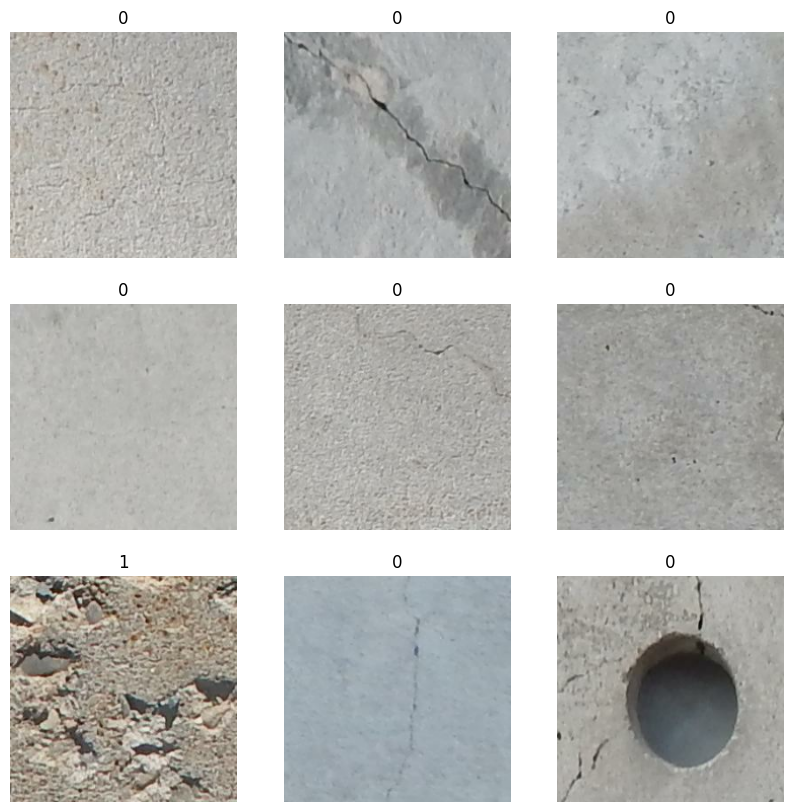

In [3]:
##Taking a look to the images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [4]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

2024-08-08 14:15:32.131010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


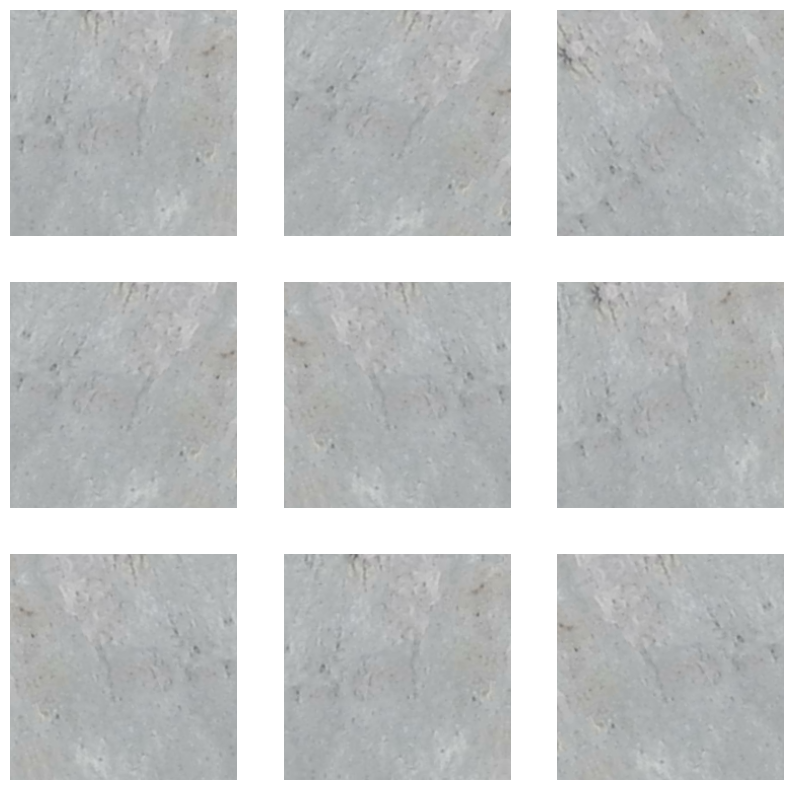

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [7]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [8]:
def make_model_1(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model_1(input_shape=image_size + (3,), num_classes=2)
##keras.utils.plot_model(model, show_shapes=True)

In [9]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - acc: 0.6033 - loss: 0.8664 - val_acc: 0.5000 - val_loss: 0.6931
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - acc: 0.5272 - loss: 0.7999 - val_acc: 0.5000 - val_loss: 0.6934
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - acc: 0.5742 - loss: 0.7690 - val_acc: 0.5000 - val_loss: 0.6938
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - acc: 0.5294 - loss: 0.7137 - val_acc: 0.5000 - val_loss: 0.6943
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - acc: 0.5237 - loss: 0.7659 - val_acc: 0.5000 - val_loss: 0.6955
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - acc: 0.6444 - loss: 0.6662 - val_acc: 0.5000 - val_loss: 0.6965
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - acc: 0.6226 - loss: 0.7055 - val_acc: 0.5000 - val_loss: 0.6976
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - acc: 0.5786 - loss: 0.6994 - val_acc: 0.5000 - val_loss: 0.7003
Epoch 9/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - acc: 0.5811 - loss: 

#### **Transfer Learning DenseNet169**

In [10]:
def make_transfer_model(input_shape, num_classes):
    # Load the pre-trained weights of DenseNet169 and freeze the weights
    backbone = keras.applications.DenseNet169(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False

    inputs = layers.Input(input_shape)
    x = keras.applications.densenet.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")


In [11]:
model2 = make_transfer_model(input_shape=image_size + (3,), num_classes=2)

In [12]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc")],
)

history = model2.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.4873 - loss: 0.7604 - val_acc: 0.5500 - val_loss: 0.6913
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - acc: 0.5155 - loss: 0.6956 - val_acc: 0.5750 - val_loss: 0.6755
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - acc: 0.5710 - loss: 0.6705 - val_acc: 0.5750 - val_loss: 0.6612
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - acc: 0.5299 - loss: 0.6555 - val_acc: 0.5750 - val_loss: 0.6499
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - acc: 0.5689 - loss: 0.6327 - val_acc: 0.5750 - val_loss: 0.6373
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - acc: 0.5656 - loss: 0.6102 - val_acc: 0.5500 - val_loss: 0.6302
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - acc: 0.6090 - loss: 0.6193 - val_acc: 0.5500 - val_loss: 0.6225
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - acc: 0.6250 - loss: 0.6172 - val_acc: 0.6000 - val_loss: 0.6135
Epoch 9/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - acc: 0.6278 - loss: 

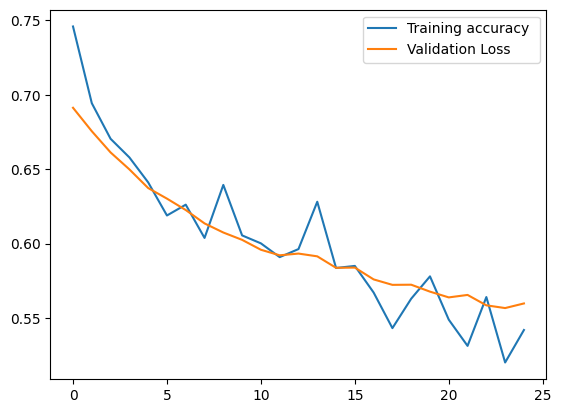

In [13]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training accuracy ")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

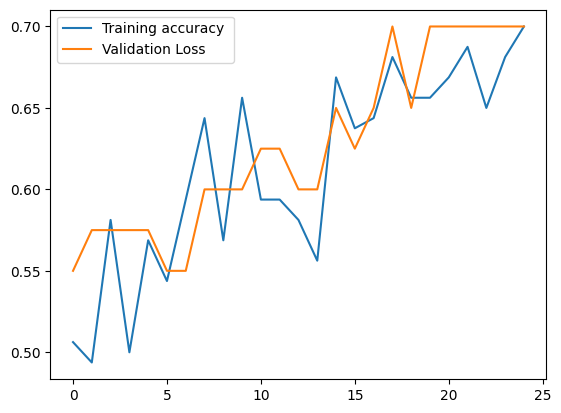

In [14]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training accuracy ")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Loss")
plt.legend()

In [15]:
model.save('make_transfer_model.keras') # Use .keras or .h5 extension

# Load the model
loaded_model_Dense = keras.models.load_model('make_transfer_model.keras')

### **A different base model**

In [16]:
from tensorflow.keras.applications import EfficientNetB0

In [17]:
def make_model_2(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    # Create EfficientNetB0 base model
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=inputs)
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Add custom layers on top
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x)
    
    if num_classes == 2:
        units = 1
    else:
        units = num_classes
    
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    model = keras.Model(inputs, outputs)
    return model

model = make_model_2(input_shape=image_size + (3,), num_classes=2)
##keras.utils.plot_model(model, show_shapes=True)

In [18]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 727ms/step - acc: 0.4396 - loss: 0.7596 - val_acc: 0.5000 - val_loss: 0.7452
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 590ms/step - acc: 0.4893 - loss: 0.7426 - val_acc: 0.5000 - val_loss: 0.7362
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 623ms/step - acc: 0.5683 - loss: 0.7171 - val_acc: 0.5000 - val_loss: 0.7258
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 580ms/step - acc: 0.5141 - loss: 0.6875 - val_acc: 0.5250 - val_loss: 0.7181
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 558ms/step - acc: 0.5237 - loss: 0.6773 - val_acc: 0.5250 - val_loss: 0.7096
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 567ms/step - acc: 0.5379 - loss: 0.6888 - val_acc: 0.5250 - val_loss: 0.7015
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 565ms/step - acc: 0.6046 - loss: 0.6604 - val_acc: 0.5250 - val_loss: 0.6937
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 561ms/step - acc: 0.5626 - loss: 0.6691 - val_acc: 0.5250 - val_loss: 0.6877
Epoch 9/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 565ms/step - 

In [19]:
model.save('make_model_2.keras') # Use .keras or .h5 extension

# Load the model
loaded_model_2 = keras.models.load_model('make_model_2.keras')